In [ ]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import sklearn

# ---- GLOBAL PLOT SETTINGS ----

# for converting cm to inches
cm = 1/2.54

# Set global plot style
plt.rcParams.update({
    "figure.figsize": (18*cm, 8*cm),   # default: 18×8 cm
    "font.size": 10,                    # Standardschriftgröße
    "axes.titlesize": 10,
    "axes.labelsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.dpi": 300, # für saubere Notebooks/Export
    "lines.linewidth": 1.0,
    "lines.markersize": 4,
    "axes.linewidth": 1.0,
    "xtick.major.width": 1.0,
    "ytick.major.width": 1.0,
    "xtick.minor.width": 1.0,
    "ytick.minor.width": 1.0,
})


In [2]:
df = pd.read_csv("data/rakuten_explored.csv")
df.head(10)

,designation,description,productid,imageid,prdtypecode,image_file,category,text,lang_hf,lang_langdetect,char_len,token_len,product_keywords
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,10,image_1263597046_product_3804725264.jpg,books,Olivia: Personalisiertes Notizbuch / 150 Seite...,de,de,89,14,books
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,2280,image_1008141237_product_436067568.jpg,magazines,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,fr,fr,207,39,magazines
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,50,image_938777978_product_201115110.jpg,"gaming, electronics",Grand Stylet Ergonomique Bleu Gamepad Nintendo...,fr,fr,837,121,gaming accessories
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,1280,image_457047496_product_50418756.jpg,"toys, action figures",Peluche Donald - Europe - Disneyland 2000 (Mar...,fr,de,64,10,toys
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,2705,image_1077757786_product_278535884.jpg,books,La Guerre Des Tuques Luc a des id&eacute;es de...,fr,fr,234,38,books
5,Afrique Contemporaine N° 212 Hiver 2004 - Doss...,NaN,5862738,393356830,2280,image_393356830_product_5862738.jpg,magazines,Afrique Contemporaine N° 212 Hiver 2004 - Doss...,fr,fr,66,11,magazines
6,Christof E: Bildungsprozessen Auf Der Spur,NaN,91920807,907794536,10,image_907794536_product_91920807.jpg,books,Christof E: Bildungsprozessen Auf Der Spur,de,de,43,6,books
7,Conquérant Sept Cahier Couverture Polypro 240 ...,CONQUERANT CLASSIQUE Cahier 240 x 320 mm seyès...,344240059,999581347,2522,image_999581347_product_344240059.jpg,office supplies,Conquérant Sept Cahier Couverture Polypro 240 ...,fr,fr,204,32,stationery
8,Puzzle Scooby-Doo Avec Poster 2x35 Pieces,NaN,4239126071,1325918866,1280,image_1325918866_product_4239126071.jpg,"toys, action figures",Puzzle Scooby-Doo Avec Poster 2x35 Pieces,fr,pl,42,6,toys
9,Tente Pliante V3s5-Pro Pvc Blanc - 3 X 4m50 - ...,Tente pliante V3S5 Pro PVC 500 gr/m² - 3 x 4m5...,3793572222,1245644185,2582,image_1245644185_product_3793572222.jpg,"garden, household",Tente Pliante V3s5-Pro Pvc Blanc - 3 X 4m50 - ...,fr,fr,2459,312,home and garden


In [3]:
from bs4 import BeautifulSoup
import re

def has_html(text: str) -> bool:
    if not isinstance(text, str):
        return False
    return bool(re.search(r"<[^>]+>", text))


def strip_html(text: str) -> str:
    if not text:
        return ""
    
    # check if text contains HTML tags
    if "<" not in text or ">" not in text:
        # print("No HTML detected.")
        return text
    # print("HTML detected, stripping tags...")
    # print("Original text:", text)
    # parse and clean HTML content
    cleaned_text = BeautifulSoup(text, "html.parser").get_text(" ").strip()
    
    # print("Cleaned text:", cleaned_text)
    return cleaned_text


def lowercase_text(text: str) -> str:
    return text.lower()

In [4]:
# check how many texts contain html
df['has_html'] = df['text'].apply(has_html)
print(f"Number of texts with HTML content: {df['has_html'].sum()} out of {len(df)}")

# apply strip_html to all rows which have html
df["text_stripped"] = df["text"].apply(lambda x: strip_html(x) if has_html(x) else x)

# lowercase all text in text_stripped column
df["text_stripped_lowercase"] = df["text_stripped"].apply(lowercase_text)


# do same processing for designation and description columns
df["designation_stripped"] = df["designation"].apply(lambda x: strip_html(x) if has_html(x) else x)
df["description_stripped"] = df["description"].apply(lambda x: strip_html(x) if has_html(x) else x)




Number of texts with HTML content: 15646 out of 84916


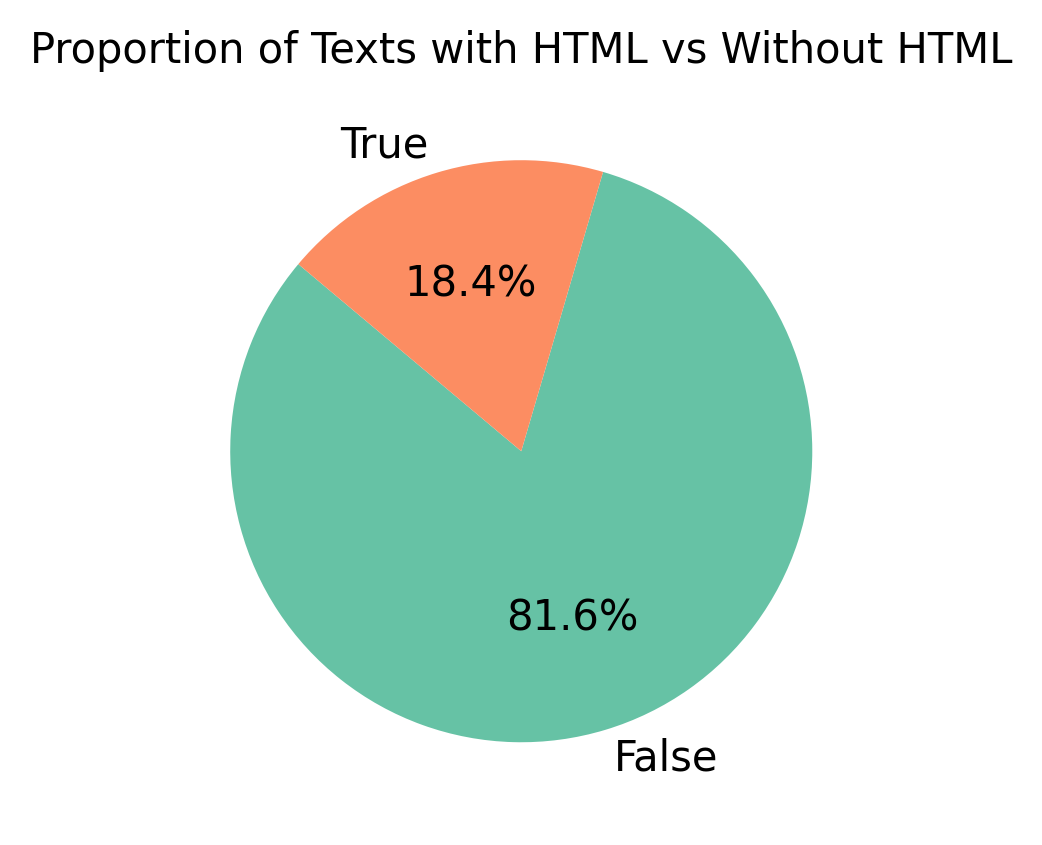

In [5]:
# pie chart of texts with html vs without html
html_counts = df['has_html'].value_counts()
plt.figure(figsize=(8*cm,8*cm))
colors = sns.color_palette('Set2')
plt.pie(html_counts, labels=html_counts.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title("Proportion of Texts with HTML vs Without HTML")
plt.show()

In [6]:
# show an example of a text with html before and after stripping
# select a row which has html
row = df[df['has_html']].index[4]
dirty_text = df.loc[row, "text"]
cleaned = df.loc[row, "text_stripped"]
print("=== Dirty Text ===")
print(dirty_text)
print("\n=== Cleaned Text ===")
print(cleaned)

=== Dirty Text ===
Lampe De Lecture Rechargeable Led Lampe De Beauté Lampe De Protection Des Yeux Lampe Froide Col De Cygne Lampe Moderne Lampe De Bureau Rechargeable Nom de la marque:SYTH<br />Ampoules incluses:Oui<br />Certification:CCC<br />Matériel du corps:En aluminium<br />Type d&#39;ombre:ABS<br />Voltage:5V<br />Matériel:En aluminium<br />Numéro du modèle:SYTH-DMSH-001<br />Style:Moderne<br />Type de découpage:Bouton-Poussoir<br />Source de lumière:Ampoules à led<br />Type de l&#39;article:Lampes de bureau<br />Source d&#39;énergie:Dc<br />Terminer:Fer<br />Réglable:Oui<br />feature 1:table lamp<br />feature 2:desk lamp<br />feature 3:led table lamp<br />feature 4:led desk lamp<br />feature 5:study lamp<br />feature 6:table light<br />feature 7:usb led<br />feature 8:book light<br />feature 9:reading light<br />feature 10:reading lamp

=== Cleaned Text ===
Lampe De Lecture Rechargeable Led Lampe De Beauté Lampe De Protection Des Yeux Lampe Froide Col De Cygne Lampe Moderne Lamp

In [7]:
# look for the number of exact duplicate texts in the text_stripped column
num_duplicates = df['text_stripped'].duplicated().sum()
print(f"Number of exact duplicate texts in 'text_stripped': {num_duplicates}")
# show an example of duplicate texts, with showing both texts and their indices
duplicate_texts = df[df['text_stripped'].duplicated(keep=False)]['text_stripped'].unique()
print("\n=== Example Duplicate Texts ===")
for text in duplicate_texts[:5]:  # show first 5 examples
    indices = df[df['text_stripped'] == text].index.tolist()
    print(f"Indices: {indices}")
    print(text)
    print("---")
    
print(df.iloc[9],df.iloc[18374])
# show the image for both indices
# for idx in [9, 18374]:
#     image_path = os.path.join(image_folder, df.loc[idx, 'image_file'])
#     image = cv2.imread(image_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     plt.imshow(image)
#     plt.title(f"ID: {idx}")
#     plt.axis('off')
#     plt.show()

Number of exact duplicate texts in 'text_stripped': 1415

=== Example Duplicate Texts ===
Indices: [9, 18374, 30164, 31448, 37705, 46951, 47446, 63785, 81480]
Tente Pliante V3s5-Pro Pvc Blanc - 3 X 4m50 - Longueur : 4m50 Largeur : 3 M Blanc H Tente pliante V3S5 Pro PVC 500 gr/m² - 3 x 4m50.Que vous soyez un particulier pour votre jardin ou un professionnel pour stand commercial ou pour vos réceptions le barnum V3S5 Pro de 135 m² sera vous combler.Imaginez un  stand  robuste léger adaptable à chacun pliable et peu encombrant... Le déploiement ultra-rapide et le réglage de la hauteur se font maintenant via des poignées d'indexage. Nous avons également entièrement repensé les pièces de jonction et les coulissants : plus rigides et légères elles sont aussi maintenant 30% plus résistantes.  la  tente pliante  V3 Pro de  qualité professionnelle  et de  fabrication française  est complètement adaptable et deviendra l'outil indispensable à votre activité. Toujours en vue d'améliorer votre quot

In [8]:
# remove duplicate texts based on text_stripped column, keep the first occurrence
df = df.drop_duplicates(subset=['text_stripped'], keep='first').reset_index(drop=True)


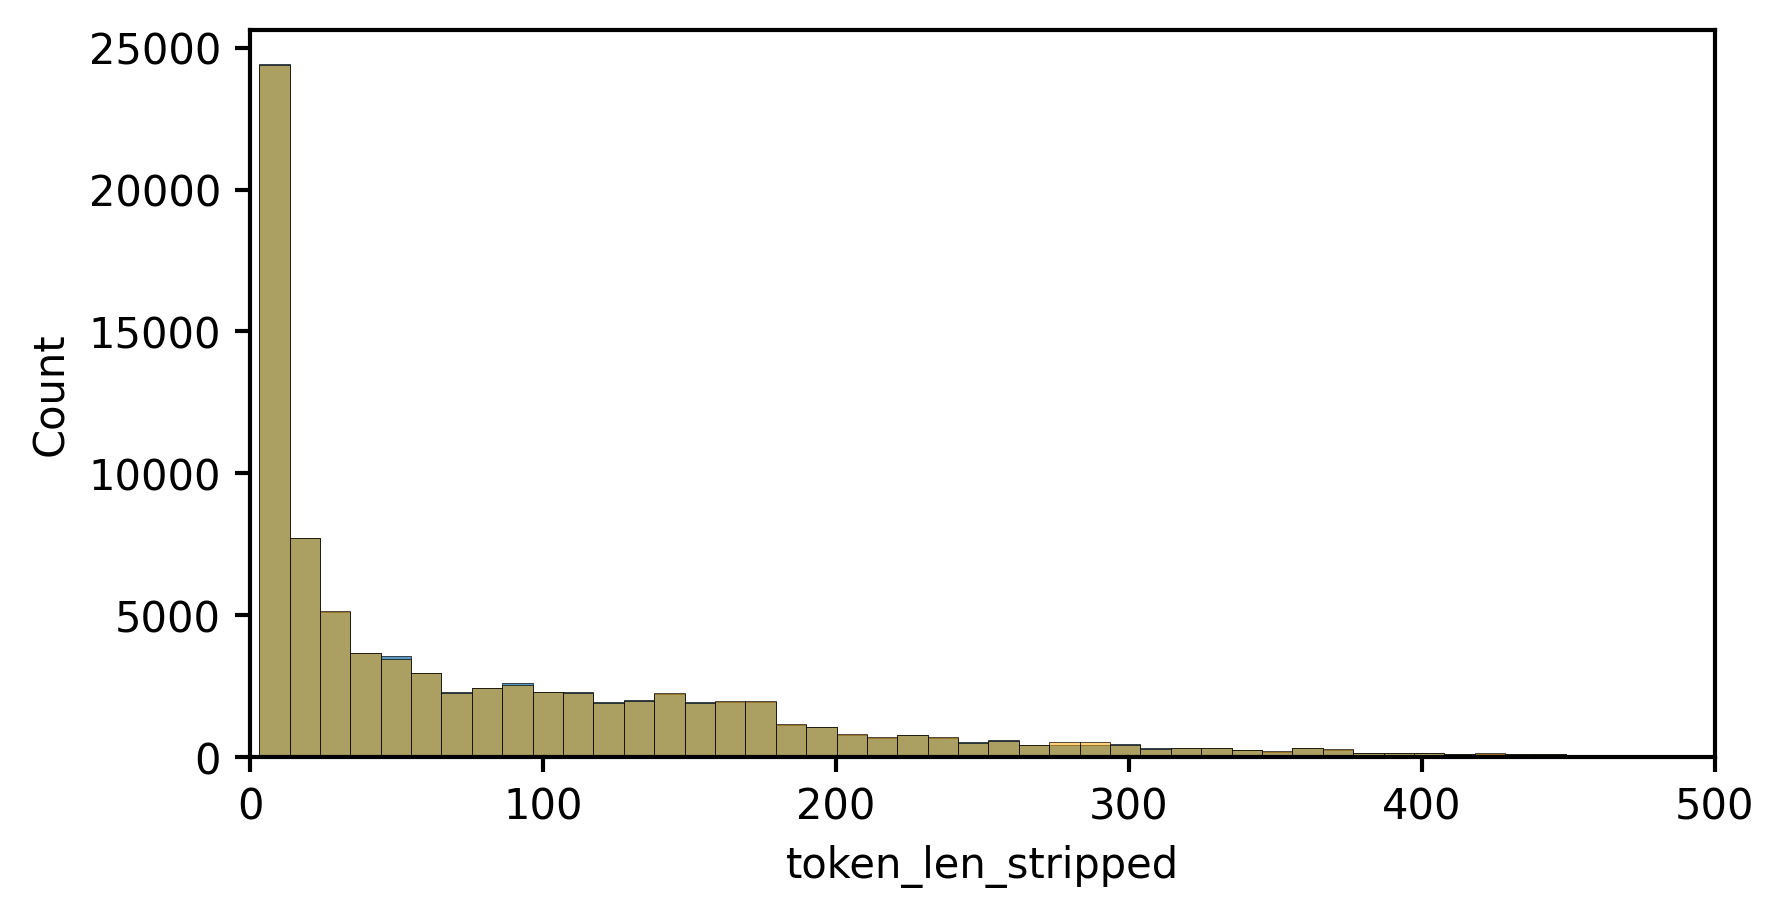

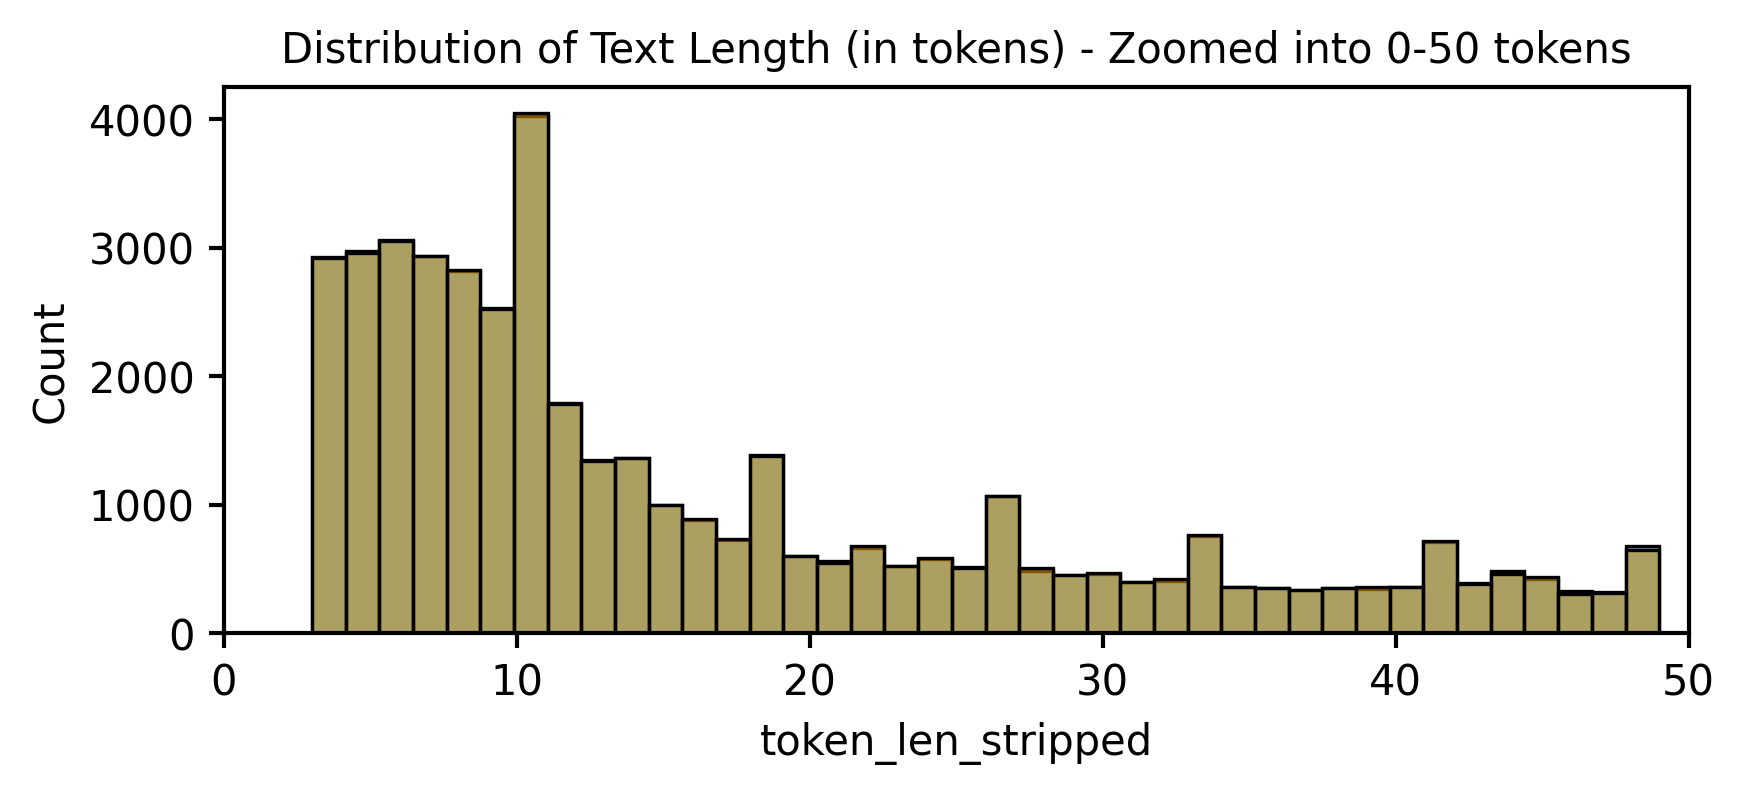

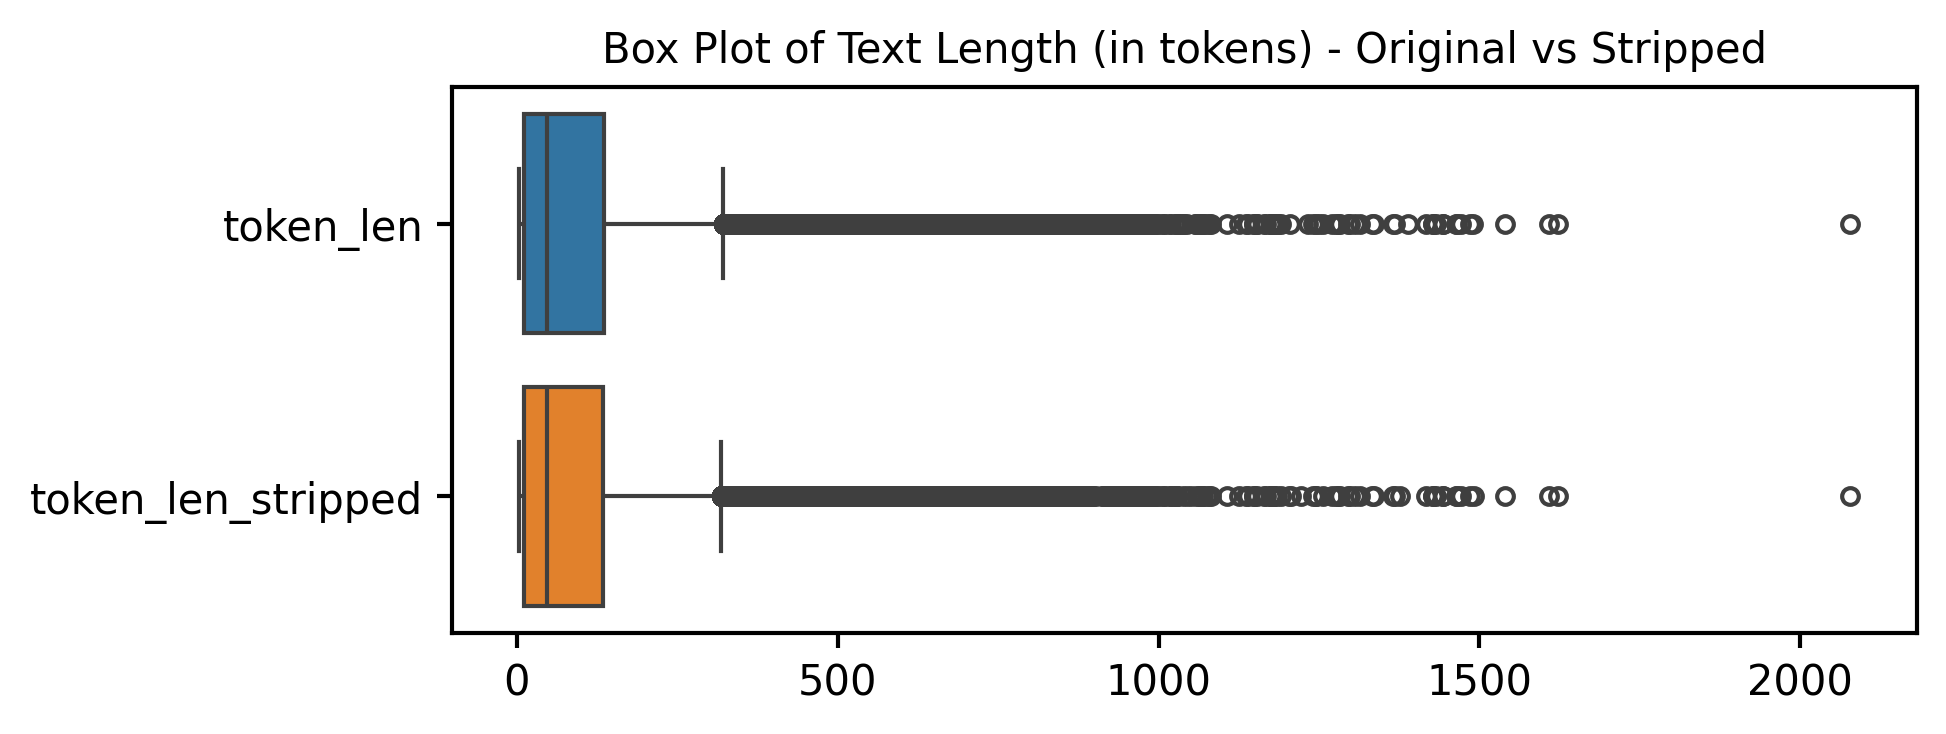

,productid,imageid,prdtypecode,char_len,token_len,token_len_stripped
count,8.350100e+04,8.350100e+04,83501.000000,83501.000000,83501.000000,83501.000000
mean,2.533941e+09,1.150826e+09,1770.535431,588.041640,90.586568,89.878504
std,1.590585e+09,1.757590e+08,789.572849,759.930887,115.975974,115.015123
min,1.839120e+05,6.728400e+04,10.000000,12.000000,3.000000,3.000000
25%,6.106543e+08,1.053451e+09,1281.000000,65.000000,11.000000,11.000000
50%,3.128811e+09,1.209687e+09,1920.000000,302.000000,47.000000,47.000000
75%,3.993166e+09,1.275538e+09,2522.000000,890.000000,135.000000,134.000000
max,4.252012e+09,1.328824e+09,2905.000000,12536.000000,2078.000000,2078.000000


In [9]:
# show token length distribution again after stripping html and lowercasing, and removing duplicates and compare to before
# white space tokenization length distribution
df['token_len_stripped'] = df['text_stripped'].astype(str).apply(lambda x: len(x.split()))

plt.figure(figsize=(16*cm,8*cm))
sns.histplot(data=df, x='token_len_stripped', bins=200)
sns.histplot(data=df, x='token_len', bins=200, color='orange', alpha=0.5, label='Original')
plt.xlim(0, 500)
# plt.title("Distribution of Text Length (in tokens)")
# plt.yscale('log')
plt.show()



# zoom into 0-50 range in new figure
plt.figure(figsize=(16*cm,6*cm))
df_less_50tok = df[df['token_len_stripped'] < 50]
sns.histplot(data=df_less_50tok, x='token_len_stripped', bins=40)

df_less_50tok_orig = df[df['token_len'] < 50]
sns.histplot(data=df_less_50tok_orig, x='token_len', bins=40, color='orange', alpha=0.5, label='Original')

plt.xlim(0, 50)
plt.title("Distribution of Text Length (in tokens) - Zoomed into 0-50 tokens")
plt.show()


# box plot for both token_len and token_len_stripped, horizontal box plot
plt.figure(figsize=(16*cm,6*cm))
sns.boxplot(data=df[['token_len', 'token_len_stripped']], orient='h')
plt.title("Box Plot of Text Length (in tokens) - Original vs Stripped")
plt.show()

df.describe()

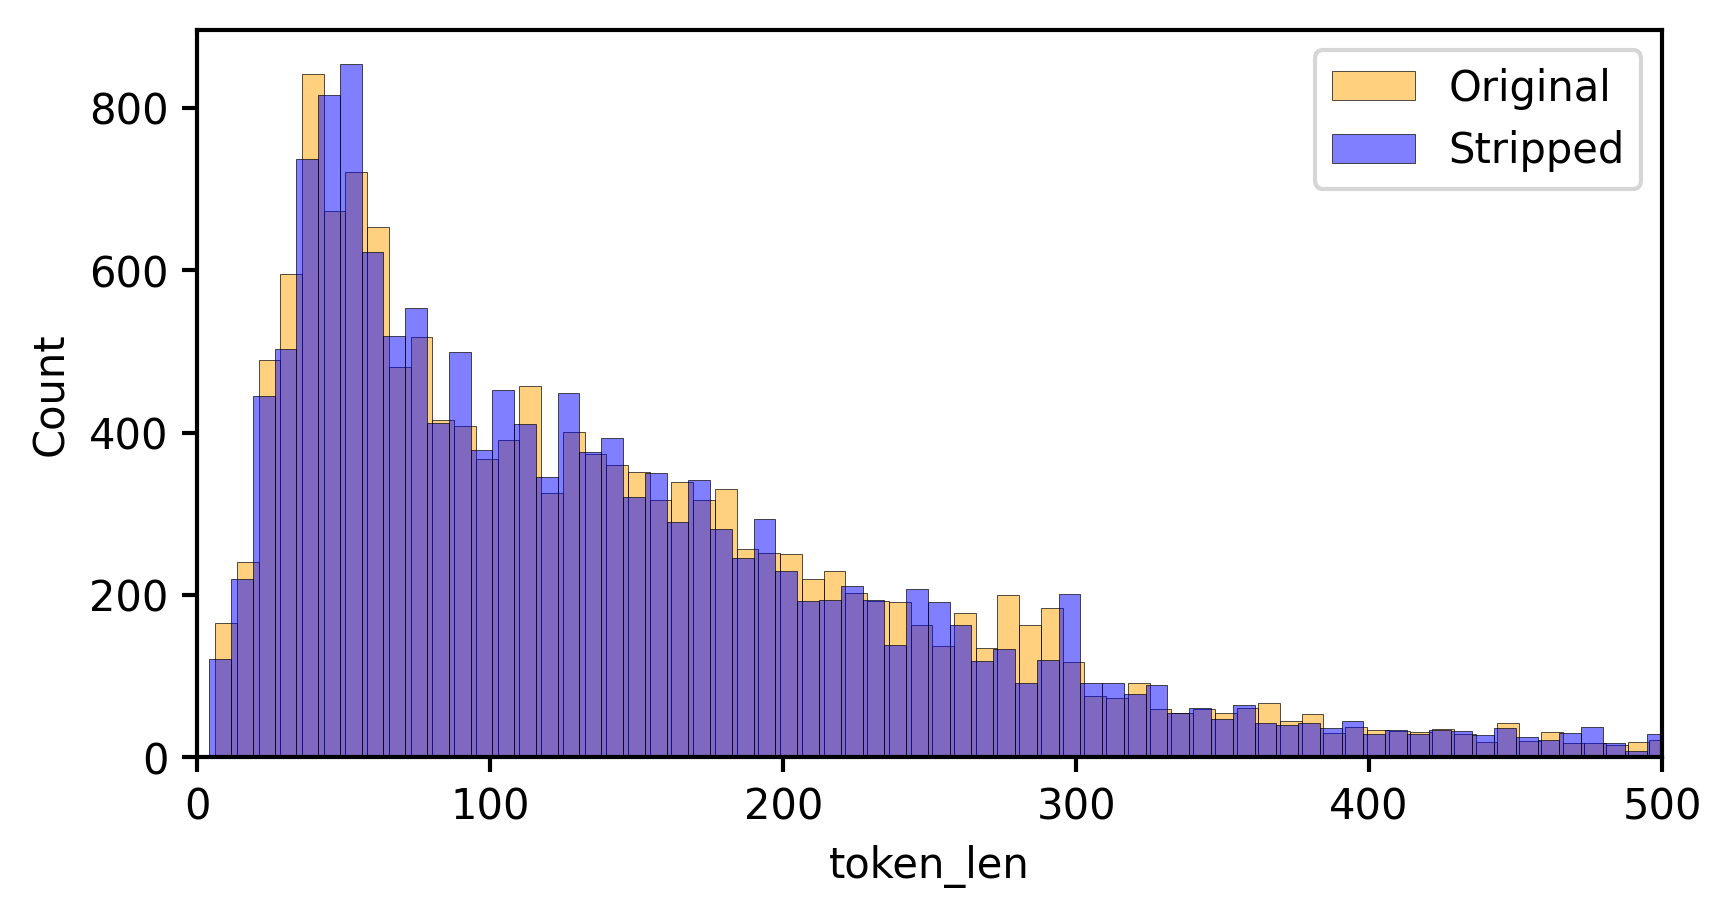

In [10]:
# show only for the html texts the token length distribution before and after stripping
df_html = df[df['has_html']]
plt.figure(figsize=(16*cm,8*cm))
sns.histplot(data=df_html, x='token_len', bins=200, color='orange', alpha=0.5, label='Original')
sns.histplot(data=df_html, x='token_len_stripped', bins=200, color='blue', alpha=0.5, label='Stripped')
plt.xlim(0, 500)
plt.legend()

In [11]:
df.to_csv('data/rakuten_processed.csv', index=False)


In [14]:
df = pd.read_csv("data/rakuten_processed.csv")

In [15]:
df.head(10)
product_id = 121842876     # example productid
product_row = df[df['productid'] == product_id].iloc[0]
print("Designation:", product_row['designation'])
print("English:",product_row["text_english"])

Designation: Soldat Dragon De L'ultime Destinée Lodt-Jp042
English: Dragon Soldier of Ultimate Destiny lodt-jp042
